### Ridge Regression

#### Approaches used
- Estimate weights by solving ERM $\bf{w} = (A^\intercal A + \lambda \bf{I})^{-1} A^\intercal \bf{b}$.
- Estimate intercept by $w_0 = \bf\bar{Y} - \bf{w}^\intercal \bf{\bar{X}} $
- Calculte RMSE by $RMSE = \frac{\sum(\bf{Y}-\bf{\hat{Y}})^2}{n_i}$, where $n_i$ is the number of observations for either validation or training dataset.

#### Implementing Ridge regression

In [72]:
# Import necessary modules
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [84]:
# Define standardization function
def standardize(X):
    mu,sd = np.average(X,axis = 0), np.std(X,axis = 0)
    X0 = (X - np.array([mu,]*X.shape[0])) / np.array([sd,]*X.shape[0])
    return X0

In [85]:
# Shuffle and partition the shuffled data into k=5 different folds

def partition(k,df):
    
    # Randomly shuffle the data by sampling and reset index
    df_shuffled = df.sample(frac=1).reset_index(drop=True)
    ni = int(df.shape[0]/k) # compute the number of rows of each fold

    # creat dictionaries
    X_shuffled = {}
    y_shuffled = {}
    
    # partition the data
    for i in range(1,k+1):
        X_shuffled[i], y_shuffled[i] = df_shuffled.iloc[0:ni,0:13], df_shuffled.iloc[0:ni,13]
        df_shuffled = df_shuffled.reset_index(drop=True)
        df_shuffled = df_shuffled.drop(range(0,ni),axis = 0)
        df_shuffled = df_shuffled.reset_index(drop=True)
    
    return X_shuffled, y_shuffled

In [86]:
def get_next_train_valid(X_shuffled, y_shuffled, itr):
    
    X_valid, y_valid = X_shuffled[itr], y_shuffled[itr] # select the itr fold for validation
    
    # Creat new dictionaries to store data for training
    X_for_train = {n: X_shuffled[n] for n in range(1,6) if n!=itr}
    y_for_train = {n: y_shuffled[n] for n in range(1,6) if n!=itr}
    
    # Concatenate the rest of folds for training
    X_train,y_train = pd.concat(X_for_train.values()), pd.concat(y_for_train.values())
    
    return X_train, y_train, X_valid, y_valid

In [97]:
# Define training model with implementation of Ridge regression solution

def train(X_train,y_train,lam):
    
    # Convert panda df to numpy arrays
    A = np.array(X_train)
    I = np.diag(np.repeat(1,X_train.shape[1]))
    b = np.array(y_train)
    
    carr = A.T@A + lam*I
    weights = np.linalg.inv(carr)@A.T@b
    intercept = np.average(b)
    #intercept = np.average(b) - weights.T@np.average(A,axis=0)
    return weights, intercept

In [89]:
# Define predicting function
def predict(X_valid,model_weights, model_intercept):
    
    ni = X_valid.shape[0]
    y_predict = np.array([model_intercept]*ni) + X_valid @ model_weights
    
    return y_predict

In [106]:
# Integrate the functions above

# Import data
df = np.array(pd.read_csv("Housing.csv"))
df[:,0:13] = standardize(df[:,0:13])
df = pd.DataFrame(df)

while True:
    
    k=5 # specify the number of folds
    
    # randomly shuffle and partition data into k folds and store in dictionary
    X_shuffled, y_shuffled = partition(k,df)
    
    
    # Creat lists to store the mean RMSE
    mRMSE_train = []
    mRMSE_valid = []
    lamd = []
    
    # Cross validation by using different lambdas
    for lam in range(0,101,1):
        
        RMSE_train = [] # to store the rmse in each step
        RMSE_valid = []
        lamd.append(lam)
        
        for itr in range(1,6):
            
            X_train, y_train, X_valid, y_valid = get_next_train_valid(X_shuffled, y_shuffled, itr)
            X_train, y_train,X_valid, y_valid = np.array(X_train), np.array(y_train),np.array(X_valid), np.array(y_valid)
            model_weights, model_intercept = train(X_train,y_train,lam)
            y_predict_valid = predict(X_valid,model_weights, model_intercept)
            y_predict_train = predict(X_train, model_weights, model_intercept)
            
            # Store training and testing MSE
            RMSE_train.append((np.sum((y_predict_train - np.array(y_train))**2))/404)
            RMSE_valid.append((np.sum((y_predict_valid- np.array(y_valid))**2))/101)
            
        #Compute the mean RMSE 
        mRMSE_train.append(np.average(RMSE_train))
        mRMSE_valid.append(np.average(RMSE_valid))
        
    break

#### Mean RMSE and plot

In [ ]:
# Mean RMSE for training and valiation
print(mRMSE_train)
print(mRMSE_valid)

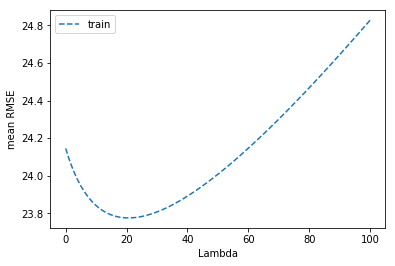

In [107]:
# Plot training mean RMSE vs. Lambda 
plt.plot(lamd,mRMSE_train,linestyle = 'dashed',label = 'train')
#plt.plot(lamd,mRMSE_valid,label = 'valid')
plt.ylabel('mean RMSE')
plt.xlabel('Lambda')
plt.legend()

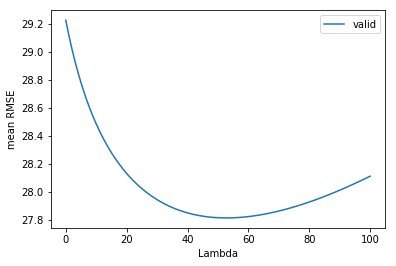

In [108]:
# Plot testing mean RMSE vs. Lambda 
plt.plot(lamd,mRMSE_valid,label = 'valid')
plt.ylabel('mean RMSE')
plt.xlabel('Lambda')
plt.legend()

- From the training errors we can see by increasing the value of $\lambda$ we introduced some bias into our estimation. 
- The testing error firstly decreased and then kept increased. 
- This might suggest that we have some over-fitting issues in the model. We can choose the lambda which gives the smallest error.